In [ ]:
gin.enter_interactive_mode()

In [ ]:
import w1d4_tests

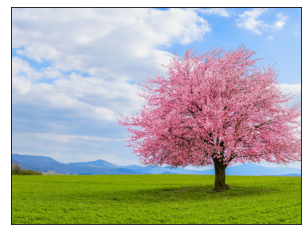

In [ ]:
fname = "/home/ubuntu/mlab/days/w1d4/cherry.jpg"
w1d4_tests.plot_image(fname)

In [ ]:
data_train, data_test = w1d4_tests.load_image(fname)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

@gin.configurable
class Model(nn.Module):
    def __init__(self, P, H, K):
        super(Model, self).__init__()
        self.linear1 = nn.Linear(P, H)
        self.linear2 = nn.Linear(H, H)
        self.linear3 = nn.Linear(H, K)

    def forward(self, x0):
        x1 = F.relu(self.linear1(x0))
        x2 = F.relu(self.linear2(x1))
        return self.linear3(x2)

In [ ]:
w1d4_tests.test_mlp(Model)

Congrats! You've passed the test.


In [ ]:
from torch import optim

def train(model, dataloader, lr, momentum):
    optimizer = optim.SGD(model.parameters(), lr, momentum)
    for input, target in dataloader:
        optimizer.zero_grad()
        output = model(input)
        loss = F.l1_loss(output, target)
        loss.backward()
        optimizer.step() 
    return model

In [ ]:
w1d4_tests.test_train(train)

Congrats! You've passed the test.


In [ ]:
import torch as t

def evaluate(model, dataloader):
    with t.no_grad():
        loss = 0
        num_inputs = 0
        for input, target in dataloader:
            num_inputs += 1
            output = model(input)
            loss += F.l1_loss(output, target)
        return loss/num_inputs

In [ ]:
w1d4_tests.test_evaluate(evaluate)

Congrats! You've passed the test.


In [ ]:
model = Model(P=2, H=400, K=3)

In [ ]:
import matplotlib.pyplot as plt

def train_epochs(model, data_train, data_test, lr=0.01, momentum=0.9, num_epochs=100):
    epochs = list(range(1, num_epochs + 1))
    losses_train = []
    losses_test = []
    
    for epoch in epochs:
        model = train(model, data_train, lr=lr, momentum=momentum)
        losses_train.append(evaluate(model, data_train))
        losses_test.append(evaluate(model, data_test))
    plt.plot(epochs, losses_train)
    plt.plot(epochs, losses_test)

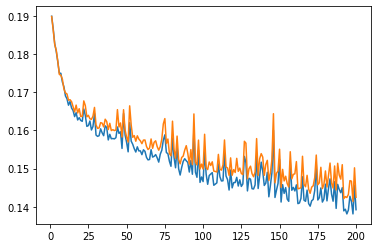

In [ ]:
train_epochs(model, data_train, data_test, num_epochs = 200)

In [ ]:
import einops

def make_image(model):
    height = 100
    width = 150
    xs = einops.repeat(t.linspace(-.5, .5, width), 'w -> h w', h = height)
    ys = einops.repeat(t.linspace(-.5, .5, height), 'h -> h w', w = width)
    pre_input = t.zeros((height, width, 2))
    pre_input[:,:,0] = xs
    pre_input[:,:,1] = ys
    input_tensor = einops.rearrange(pre_input, 'x y z -> (x y) z')
    results = einops.rearrange(model(input_tensor), '(h w) c -> h w c', h = height)
    return results + .5

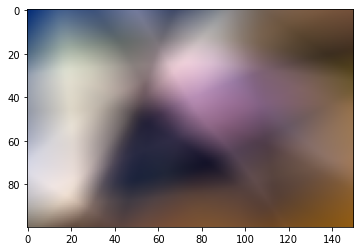

In [ ]:
with t.no_grad():
    plt.imshow(make_image(model))

In [ ]:
def f(x, y, a=1, b=100):
    return (a-x)**2 + b*(y-x**2)**2 + 1

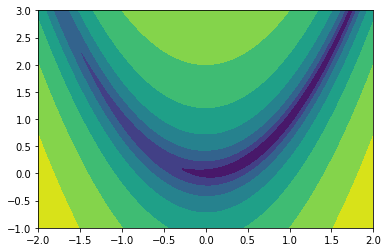

In [ ]:
import numpy as np

def contour_plot():
    height = 100
    width = 150
    xs = einops.repeat(t.linspace(-2, 2, width), 'w -> h w', h=height)
    ys = einops.repeat(t.linspace(-1, 3, height), 'h -> h w', w=width)
    zs = t.log(f(xs, ys))
    plt.contourf(xs, ys, zs)
contour_plot()

In [ ]:
def opt_rosenbrock(xy, lr, momentum, n_iter):
    optimizer = SGD([xy], lr, momentum, 0, 0)
    xys = t.zeros((n_iter + 1, 2))
    xys[0,:] = xy
    for itr in range(1, n_iter + 1):
        optimizer.zero_grad()
        loss = t.log(f(xy[0], xy[1]))
        loss.backward()
        optimizer.step()
        xys[itr,:] = xy
    return xys

In [ ]:
xy = t.tensor([-1.5, 2.5], requires_grad=True)
xys = opt_rosenbrock(xy, lr=0.01, momentum=0.5, n_iter=1000)

tensor([0.6193, 0.3212], requires_grad=True) tensor(1.5334)


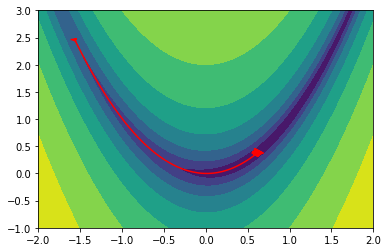

In [ ]:
def contour_plot_with_trajectory(xys):
    with t.no_grad():
        height = 100
        width = 150
        xs = einops.repeat(t.linspace(-2, 2, width), 'w -> h w', h=height)
        ys = einops.repeat(t.linspace(-1, 3, height), 'h -> h w', w=width)
        zs = t.log(f(xs, ys))
        plt.contourf(xs, ys, zs)
        plt.plot(xys[0,0], xys[0,1], 'r')
        plt.plot(xys[1:,0], xys[1:,1], 'r')
        print(xys[-1,:], f(*xys[-1,:]))
    
contour_plot_with_trajectory(xys)

In [ ]:
class SGD():
    def __init__(self, params, lr, momentum, dampening, weight_decay):
        self.params = list(params)
        self.b_values = {param: None for param in self.params}
        self.lr = lr
        self.momentum = momentum
        self.dampening = dampening
        self.weight_decay = weight_decay
    
    def zero_grad(self):
        for param in self.params:
            param.grad = None
            
    def step(self):
        with t.no_grad():
            for param in self.params:
                g = param.grad + self.weight_decay * param
                if self.b_values[param] is None:
                    self.b_values[param] = g + 0.
                else:
                    self.b_values[param] = self.momentum * self.b_values[param] + (1 - self.dampening) * g
                param -= self.lr * self.b_values[param]

In [ ]:
w1d4_tests.test_sgd(SGD)


Testing configuration:  {'lr': 0.1, 'momentum': 0.0, 'dampening': 0.0, 'weight_decay': 0.0}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.1, 'momentum': 0.7, 'dampening': 0.0, 'weight_decay': 0.0}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.1, 'momentum': 0.5, 'dampening': 0.5, 'weight_decay': 0.0}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.1, 'momentum': 0.5, 'dampening': 0.5, 'weight_decay': 0.05}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.2, 'momentum': 0.8, 'dampening': 0.0, 'weight_decay': 0.05}
Congrats! You've passed the test.


In [ ]:
class RMSprop():
    def __init__(self, params, lr, alpha, eps, weight_decay, momentum):
        self.params = list(params)
        self.b_values = {param: t.zeros_like(param) for param in self.params}
        self.variances = {param: t.zeros_like(param) for param in self.params}
        self.lr = lr
        self.alpha = alpha
        self.eps = eps
        self.weight_decay = weight_decay
        self.momentum = momentum
    
    def zero_grad(self):
        for param in self.params:
            param.grad = None
            
    def step(self):
        with t.no_grad():
            for param in self.params:
                g = param.grad + self.weight_decay * param
                self.variances[param] = self.alpha * self.variances[param] + (1 - self.alpha) * g * g
                self.b_values[param] = self.momentum * self.b_values[param] + g / (t.sqrt(self.variances[param]) + self.eps)
                param -= self.lr * self.b_values[param]

In [ ]:
w1d4_tests.test_rmsprop(RMSprop)


Testing configuration:  {'lr': 0.1, 'alpha': 0.9, 'eps': 0.001, 'weight_decay': 0.0, 'momentum': 0.0}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.1, 'alpha': 0.95, 'eps': 0.0001, 'weight_decay': 0.05, 'momentum': 0.0}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.1, 'alpha': 0.95, 'eps': 0.0001, 'weight_decay': 0.05, 'momentum': 0.5}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.1, 'alpha': 0.95, 'eps': 0.0001, 'weight_decay': 0.05, 'momentum': 0.0}
Congrats! You've passed the test.


In [ ]:
@gin.configurable
class Adam():
    def __init__(self, params, lr, betas, eps, weight_decay):
        self.params = list(params)
        self.means = {param: t.zeros_like(param) for param in self.params}
        self.variances = {param: t.zeros_like(param) for param in self.params}
        self.lr = lr
        self.betas = betas
        self.eps = eps
        self.weight_decay = weight_decay
        self.time = 0
    
    def zero_grad(self):
        for param in self.params:
            param.grad = None
            
    def step(self):
        with t.no_grad():
            self.time += 1
            for param in self.params:
                g = param.grad + self.weight_decay * param
                self.means[param] = self.betas[0]*self.means[param] + (1 - self.betas[0])*g
                self.variances[param] = self.betas[1]*self.variances[param] + (1 - self.betas[1])*g*g
                mod_means = self.means[param]/(1 - self.betas[0] ** self.time)
                mod_vars = self.variances[param]/(1 - self.betas[1] ** self.time)
                param -= self.lr * mod_means/(t.sqrt(mod_vars) + self.eps)

In [ ]:
w1d4_tests.test_adam(Adam)


Testing configuration:  {'lr': 0.1, 'betas': (0.8, 0.95), 'eps': 0.001, 'weight_decay': 0.0}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.1, 'betas': (0.8, 0.9), 'eps': 0.001, 'weight_decay': 0.05}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.2, 'betas': (0.9, 0.95), 'eps': 0.01, 'weight_decay': 0.08}
Congrats! You've passed the test.


In [ ]:
def opt_rosenbrock(xy, lr, momentum, n_iter):
    optimizer = SGD([xy], lr, momentum, 0, 0)
    xys = t.zeros((n_iter + 1, 2))
    xys[0,:] = xy
    for itr in range(1, n_iter + 1):
        optimizer.zero_grad()
        loss = t.log(f(xy[0], xy[1]))
        loss.backward()
        optimizer.step()
        xys[itr,:] = xy
    return xys

In [ ]:
xy = t.tensor([-1.5, 2.5], requires_grad=True)
xys = opt_rosenbrock(xy, lr=0.01, momentum=0, n_iter=1000)

tensor([0.4219, 0.2559], requires_grad=True) tensor(1.9416)


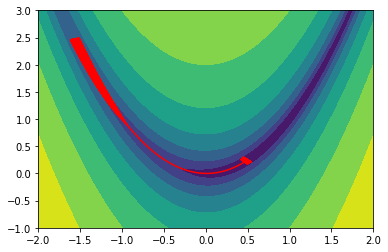

In [ ]:
contour_plot_with_trajectory(xys)

In [ ]:
def opt_rosenbrock_rmsprop(xy, lr, alpha, eps, weight_decay, momentum, n_iter):
    optimizer = RMSprop([xy], lr, alpha, eps, weight_decay, momentum)
    xys = t.zeros((n_iter + 1, 2))
    xys[0,:] = xy
    for itr in range(1, n_iter + 1):
        optimizer.zero_grad()
        loss = t.log(f(xy[0], xy[1]))
        loss.backward()
        optimizer.step()
        xys[itr,:] = xy
    return xys

In [ ]:
xy = t.tensor([-1.5, 2.5], requires_grad=True)
xys = opt_rosenbrock_rmsprop(xy, 0.01, 0.99, 1e-08, 0, 0, n_iter=1000)

tensor([0.7782, 0.6185], requires_grad=True) tensor(1.0659)


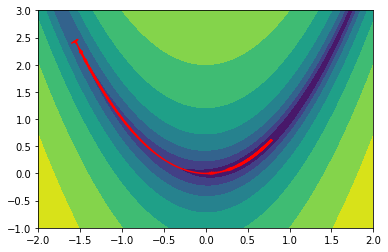

In [ ]:
contour_plot_with_trajectory(xys)

In [ ]:
def opt_rosenbrock_adam(xy, lr, betas, eps, weight_decay, n_iter):
    optimizer = Adam([xy], lr, betas, eps, weight_decay)
    xys = t.zeros((n_iter + 1, 2))
    xys[0,:] = xy
    for itr in range(1, n_iter + 1):
        optimizer.zero_grad()
        loss = t.log(f(xy[0], xy[1]))
        loss.backward()
        optimizer.step()
        xys[itr,:] = xy
    return xys

In [ ]:
xy = t.tensor([-1.5, 2.5], requires_grad=True)
xys = opt_rosenbrock_adam(xy, 0.01, (0.9, 0.999), 1e-08, 0, n_iter=1000)

tensor([0.9804, 0.9612], requires_grad=True) tensor(1.0004)


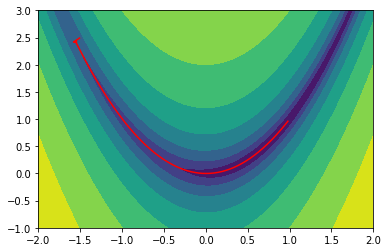

In [ ]:
contour_plot_with_trajectory(xys)

In [ ]:
model = Model(P=2, H=400, K=3)

def train(model, dataloader, optimizer_fn=optim.SGD, **opt_params):
    optimizer = optimizer_fn(model.parameters(), **opt_params)
    for input, target in dataloader:
        optimizer.zero_grad()
        output = model(input)
        loss = F.l1_loss(output, target)
        loss.backward()
        optimizer.step() 
    return model

def train_epochs(model, data_train, data_test, optimizer_fn=optim.SGD, num_epochs=100, **opt_params):
    epochs = list(range(1, num_epochs + 1))
    losses_train = []
    losses_test = []
    
    for epoch in epochs:
        model = train(model, data_train, optimizer_fn, **opt_params)
        losses_train.append(evaluate(model, data_train))
        losses_test.append(evaluate(model, data_test))
    plt.plot(epochs, losses_train)
    plt.plot(epochs, losses_test)

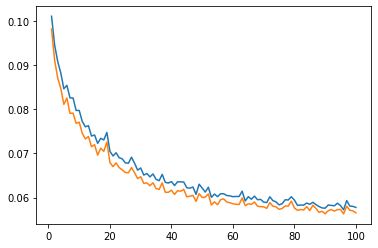

In [ ]:
opt_params = {
    "lr": 0.001, 
    "betas": (0.9, 0.999),
    "eps": 1e-08,
    "weight_decay": 0
}
train_epochs(model, data_train, data_test, optimizer_fn=Adam, num_epochs=100, **opt_params)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


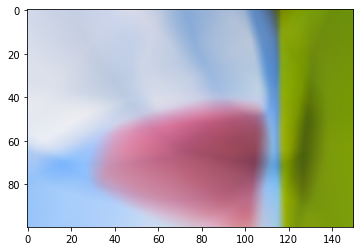

In [ ]:
with t.no_grad():
    image = make_image(model)
    plt.imshow(make_image(model))

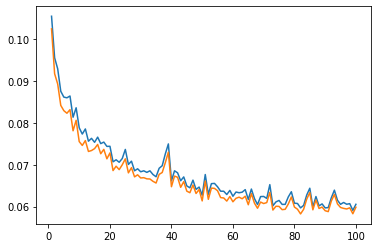

In [ ]:
import gin

model = Model(P=2, H=400, K=3)

@gin.configurable
def gin_train(model, data_train, data_test, optimizer_fn, num_epochs, lr, betas, eps, weight_decay):
    epochs = list(range(1, num_epochs + 1))
    losses_train = []
    losses_test = []
    
    for epoch in epochs:
        optimizer = None
        if optimizer_fn == "Adam":
            optimizer = Adam(model.parameters(), **opt_params)
        for input, target in data_train:
            optimizer.zero_grad()
            output = model(input)
            loss = F.mse_loss(output, target)
            loss.backward()
            optimizer.step()
        losses_train.append(evaluate(model, data_train))
        losses_test.append(evaluate(model, data_test))
    plt.plot(epochs, losses_train)
    plt.plot(epochs, losses_test)

if __name__ == "__main__":
    with gin.unlock_config():
        gin.parse_config_file(config_file="config.gin")
        gin_train(model, data_train, data_test)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


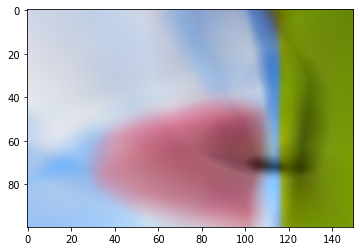

In [ ]:
with t.no_grad():
    plt.imshow(make_image(model))

In [ ]:
from operator import mul
from functools import reduce

def make_grid(possible_values):
    size = reduce(mul, map(len, possible_values.values()))
    ls = []
    for idx in range(size):
        new_values = {}
        for name, values in possible_values.items():
            new_values[name] = values[idx % len(values)]
            idx //= len(values)
        ls.append(new_values)
    return ls

In [ ]:
possible_values = {
  "gin_train.lr": np.geomspace(1e-1, 1e-3, 3),
  "Model.P": [2],
}
grid = make_grid(possible_values)
list(grid[0].items())

[('gin_train.lr', 0.1), ('Model.P', 2)]

In [ ]:
def thangify(pair):
    name, value = pair
    return f"{name}={value}"

def stringify(dictionary):
    return list(map(thangify, list(dictionary.items())))

list(map(stringify, grid))

[['gin_train.lr=0.1', 'Model.P=2'],
 ['gin_train.lr=0.01', 'Model.P=2'],
 ['gin_train.lr=0.001', 'Model.P=2']]

In [ ]:
if __name__ == "__main__":
    with gin.unlock_config():
        gin.parse_config_files_and_bindings(["config.gin"], stringify(grid[0]))

In [ ]:
help(gin.parse_config_files_and_bindings)

Help on function parse_config_files_and_bindings in module gin.config:

parse_config_files_and_bindings(config_files: Union[Sequence[str], NoneType], bindings: Union[Sequence[str], NoneType], finalize_config: bool = True, skip_unknown: Union[bool, Sequence[str]] = False, print_includes_and_imports: bool = False)
    Parse a list of config files followed by extra Gin bindings.
    
    This function is equivalent to:
    
        for config_file in config_files:
          gin.parse_config_file(config_file, skip_configurables)
        gin.parse_config(bindings, skip_configurables)
        if finalize_config:
          gin.finalize()
    
    Args:
      config_files: A list of paths to the Gin config files.
      bindings: A list of individual parameter binding strings.
      finalize_config: Whether to finalize the config after parsing and binding
        (defaults to True).
      skip_unknown: A boolean indicating whether unknown configurables and imports
        should be skipped inst